In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Bidirectional
from tensorflow.keras.optimizers import Adam
import os


In [12]:
# Mount Google Drive (hanya jika Anda menggunakan Google Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # Ganti dengan path ke file Anda di Google Drive
    BASE_DRIVE_PATH = '/content/drive/MyDrive/dataset/' # SESUAIKAN INI
    train_path = os.path.join(BASE_DRIVE_PATH, 'train.csv')
    val_path = os.path.join(BASE_DRIVE_PATH, 'valid.csv')
    test_path = os.path.join(BASE_DRIVE_PATH, 'test.csv')
except ImportError:
    print("Tidak di Google Colab. Pastikan file CSV berada di direktori yang sama atau sesuaikan path.")
    # Jika tidak di Colab, asumsikan file berada di direktori saat ini atau sesuaikan path
    train_path = 'train.csv'
    val_path = 'val.csv'
    test_path = 'test.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Fungsi untuk memuat data
def load_data(train_path, val_path, test_path):
    try:
        df_train = pd.read_csv(train_path)
        df_val = pd.read_csv(val_path)
        df_test = pd.read_csv(test_path)
        print("Data berhasil dimuat.")
        return df_train, df_val, df_test
    except FileNotFoundError:
        print(f"Error: Pastikan file CSV ada di path yang benar.")
        print(f"Mencari train.csv di: {train_path}")
        print(f"Mencari val.csv di: {val_path}")
        print(f"Mencari test.csv di: {test_path}")
        return None, None, None

df_train, df_val, df_test = load_data(train_path, val_path, test_path)

if df_train is None:
    print("Tidak dapat melanjutkan tanpa data.")
    exit()

Data berhasil dimuat.


In [9]:
print("\n--- Contoh Data Train ---")
print(df_train.head())
print("\n--- Informasi Data Train ---")
print(df_train.info())


--- Contoh Data Train ---
    id                                               text     label
0  219  Nikmati cicilan 0% hingga 12 bulan untuk pemes...   neutral
1  209  Kue-kue yang disajikan bikin saya bernostalgia...  positive
2  436               Ibu pernah bekerja di grab indonesia   neutral
3  394  Paling suka banget makan siang di sini ayam sa...  positive
4  592                    Pelayanan bus DAMRI sangat baik  positive

--- Informasi Data Train ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      500 non-null    int64 
 1   text    500 non-null    object
 2   label   500 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.8+ KB
None


In [13]:
# --- PREPROCESSING DATA UNTUK KLASIFIKASI TEKS ---

# Tentukan Kolom Fitur (text) dan Target (label)
TEXT_COLUMN = 'text'
TARGET_COLUMN = 'label'

# --- Preprocessing Teks ---
# Menggabungkan semua teks untuk membangun vocabulary yang komprehensif
all_texts = pd.concat([df_train[TEXT_COLUMN], df_val[TEXT_COLUMN], df_test[TEXT_COLUMN]])

# Inisialisasi Tokenizer
# oov_token (Out-Of-Vocabulary) untuk kata-kata yang tidak ada di corpus pelatihan
tokenizer = Tokenizer(num_words=None, oov_token="<unk>") # num_words=None untuk menyertakan semua kata
tokenizer.fit_on_texts(all_texts)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # +1 karena indeks dimulai dari 1 (0 biasanya untuk padding)
print(f"Ukuran Vocabulary: {vocab_size} kata unik.")

# Mengubah teks menjadi urutan integer
X_train_sequences = tokenizer.texts_to_sequences(df_train[TEXT_COLUMN])
X_val_sequences = tokenizer.texts_to_sequences(df_val[TEXT_COLUMN])
X_test_sequences = tokenizer.texts_to_sequences(df_test[TEXT_COLUMN])

# Menentukan panjang maksimum sekuens
# Kita bisa ambil max length dari data train atau dari gabungan data
max_sequence_length = max(len(seq) for seq in X_train_sequences)
max_sequence_length = max(max_sequence_length, max(len(seq) for seq in X_val_sequences))
max_sequence_length = max(max_sequence_length, max(len(seq) for seq in X_test_sequences))

# Jika ingin menentukan max_sequence_length secara manual (misalnya untuk mengurangi panjang input)
# max_sequence_length = 50 # Contoh, ganti jika perlu

print(f"Panjang Sekuens Maksimum: {max_sequence_length}")

# Padding sekuens agar panjangnya sama
X_train = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_val = pad_sequences(X_val_sequences, maxlen=max_sequence_length, padding='post')
X_test = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

print(f"Shape X_train setelah padding: {X_train.shape}")

Ukuran Vocabulary: 4263 kata unik.
Panjang Sekuens Maksimum: 77
Shape X_train setelah padding: (500, 77)


In [14]:
# --- Preprocessing Label ---
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(df_train[TARGET_COLUMN])
y_val_encoded = label_encoder.transform(df_val[TARGET_COLUMN])
y_test_encoded = label_encoder.transform(df_test[TARGET_COLUMN])

# Mengubah ke one-hot encoding
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes=num_classes)
y_val = to_categorical(y_val_encoded, num_classes=num_classes)
y_test = to_categorical(y_test_encoded, num_classes=num_classes)

print(f"Kelas Label: {label_encoder.classes_}")
print(f"Shape y_train setelah one-hot encoding: {y_train.shape}")

# Menentukan parameter model untuk klasifikasi
input_shape = (max_sequence_length,) # Hanya panjang sekuens, Embedding layer yang akan menangani fitur
output_units = num_classes
loss_function = 'categorical_crossentropy'
metrics_list = ['accuracy']
embedding_dim = 100 # Dimensi vektor embedding, bisa disesuaikan

Kelas Label: ['negative' 'neutral' 'positive']
Shape y_train setelah one-hot encoding: (500, 3)


In [15]:
# --- Fungsi untuk Membangun Model RNN (dengan Layer Embedding) ---
def build_rnn_model(input_shape, output_units, vocab_size, embedding_dim, num_layers, cells_per_layer, rnn_layer_type='LSTM', bidirectional=False):
    model = Sequential()
    # Layer Embedding harus menjadi layer pertama untuk input integer dari teks yang di-tokenisasi
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_shape[0]))

    if isinstance(cells_per_layer, int):
        cells_per_layer_list = [cells_per_layer] * num_layers
    elif len(cells_per_layer) != num_layers:
        raise ValueError("Panjang 'cells_per_layer' harus sama dengan 'num_layers' jika berupa list.")
    else:
        cells_per_layer_list = cells_per_layer

    for i in range(num_layers):
        return_sequences = True if i < num_layers - 1 else False

        if rnn_layer_type == 'LSTM':
            rnn_layer = LSTM(cells_per_layer_list[i], return_sequences=return_sequences)
        elif rnn_layer_type == 'GRU':
            rnn_layer = GRU(cells_per_layer_list[i], return_sequences=return_sequences)
        elif rnn_layer_type == 'SimpleRNN':
            rnn_layer = SimpleRNN(cells_per_layer_list[i], return_sequences=return_sequences)
        else:
            raise ValueError("Tipe layer RNN tidak dikenal. Pilih 'SimpleRNN', 'LSTM', atau 'GRU'.")

        if bidirectional:
            model.add(Bidirectional(rnn_layer)) # input_shape sudah dihandle oleh Embedding
        else:
            model.add(rnn_layer)

    # Output layer untuk klasifikasi multi-kelas dengan aktivasi softmax
    model.add(Dense(output_units, activation='softmax'))

    model.compile(optimizer='adam', loss=loss_function, metrics=metrics_list)
    return model

In [16]:
# --- Fungsi untuk Pelatihan dan Plotting Hasil ---
def train_and_plot(model, X_train, y_train, X_val, y_val, model_name, epochs=50, batch_size=32):
    print(f"\n--- Melatih Model: {model_name} ---")
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        verbose=0)

    # Evaluasi pada data test
    loss, metric_val = model.evaluate(X_test, y_test, verbose=0)
    print(f"Hasil Prediksi Akhir ({model_name}) pada Test Set: {metrics_list[0].upper()} = {metric_val:.4f}")

    # Plotting training dan validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return history, metric_val

In [21]:
# --- Eksperimen Variasi Hyperparameter ---

# Variabel Global untuk konsistensi eksperimen
DEFAULT_EPOCHS = 20 # Mengurangi epoch untuk eksperimen awal agar lebih cepat
DEFAULT_BATCH_SIZE = 32
DEFAULT_CELLS_PER_LAYER = 64
DEFAULT_NUM_LAYERS = 2
DEFAULT_RNN_TYPE = 'SimpleRNN'


===== Eksperimen: Pengaruh Jumlah Layer RNN =====

--- Melatih Model: RNN_Layers_1 ---
Hasil Prediksi Akhir (RNN_Layers_1) pada Test Set: ACCURACY = 0.3875


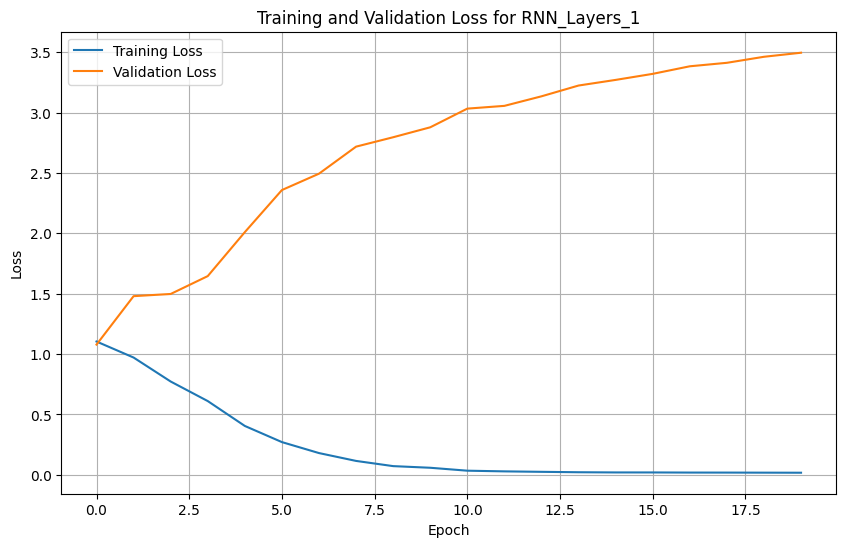


--- Melatih Model: RNN_Layers_2 ---
Hasil Prediksi Akhir (RNN_Layers_2) pada Test Set: ACCURACY = 0.3750


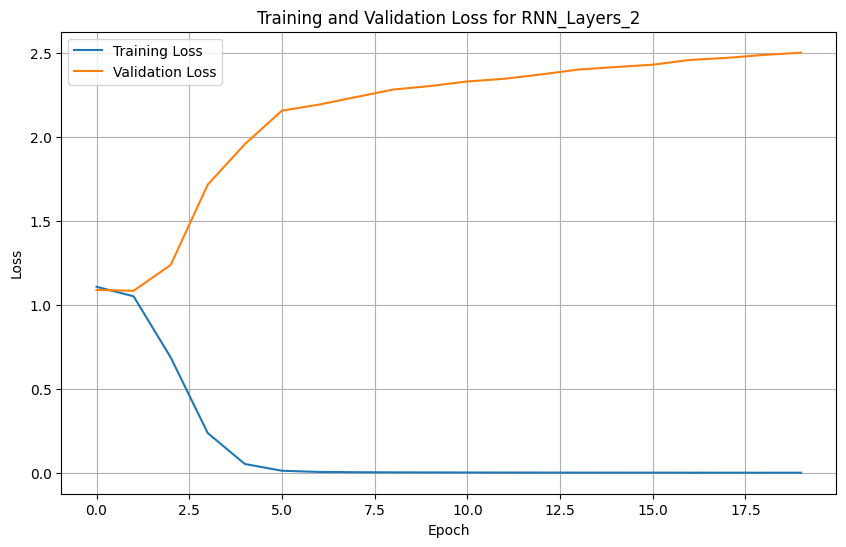


--- Melatih Model: RNN_Layers_3 ---
Hasil Prediksi Akhir (RNN_Layers_3) pada Test Set: ACCURACY = 0.3375


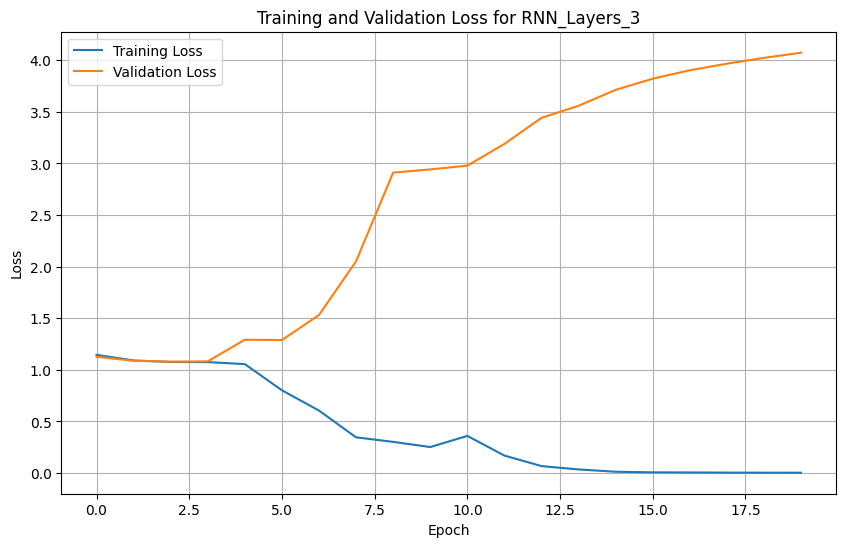


--- Perbandingan Hasil Akhir Prediksi (Jumlah Layer) ---
RNN_Layers_1: ACCURACY = 0.3875
RNN_Layers_2: ACCURACY = 0.3750
RNN_Layers_3: ACCURACY = 0.3375

--- Kesimpulan Pengaruh Jumlah Layer RNN ---
Semakin banyak layer (deep RNN), model memiliki kapasitas yang lebih besar untuk mempelajari representasi fitur yang lebih kompleks dari data sekuensial.
Namun, terlalu banyak layer dapat menyebabkan overfitting, kesulitan pelatihan (vanishing/exploding gradients), dan peningkatan waktu komputasi.
Perhatikan bagaimana training loss dan validation loss berperilaku. Jika training loss terus turun tapi validation loss meningkat, itu tanda overfitting.
Pilih jumlah layer yang memberikan keseimbangan terbaik antara kinerja pada data validasi/test dan kompleksitas model.


In [22]:

### Pengaruh Jumlah Layer RNN
print("\n===== Eksperimen: Pengaruh Jumlah Layer RNN =====")
num_layers_variations = [1, 2, 3]
results_num_layers = {}

for n_layers in num_layers_variations:
    model_name = f'RNN_Layers_{n_layers}'
    model = build_rnn_model(input_shape, output_units, vocab_size, embedding_dim,
                            num_layers=n_layers,
                            cells_per_layer=DEFAULT_CELLS_PER_LAYER,
                            rnn_layer_type=DEFAULT_RNN_TYPE,
                            bidirectional=False)
    _, final_metric = train_and_plot(model, X_train, y_train, X_val, y_val,
                                     model_name, epochs=DEFAULT_EPOCHS, batch_size=DEFAULT_BATCH_SIZE)
    results_num_layers[model_name] = final_metric

print("\n--- Perbandingan Hasil Akhir Prediksi (Jumlah Layer) ---")
for name, metric in results_num_layers.items():
    print(f"{name}: {metrics_list[0].upper()} = {metric:.4f}")

print("\n--- Kesimpulan Pengaruh Jumlah Layer RNN ---")
print("Semakin banyak layer (deep RNN), model memiliki kapasitas yang lebih besar untuk mempelajari representasi fitur yang lebih kompleks dari data sekuensial.")
print("Namun, terlalu banyak layer dapat menyebabkan overfitting, kesulitan pelatihan (vanishing/exploding gradients), dan peningkatan waktu komputasi.")
print("Perhatikan bagaimana training loss dan validation loss berperilaku. Jika training loss terus turun tapi validation loss meningkat, itu tanda overfitting.")
print("Pilih jumlah layer yang memberikan keseimbangan terbaik antara kinerja pada data validasi/test dan kompleksitas model.")



===== Eksperimen: Pengaruh Banyak Cell RNN per Layer =====

--- Melatih Model: RNN_Cells_32_per_Layer ---
Hasil Prediksi Akhir (RNN_Cells_32_per_Layer) pada Test Set: ACCURACY = 0.4025


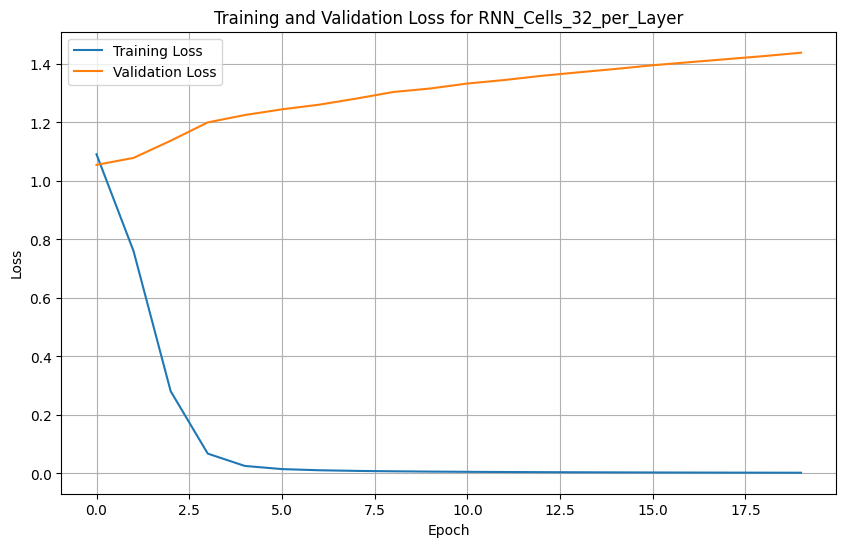


--- Melatih Model: RNN_Cells_64_per_Layer ---
Hasil Prediksi Akhir (RNN_Cells_64_per_Layer) pada Test Set: ACCURACY = 0.4000


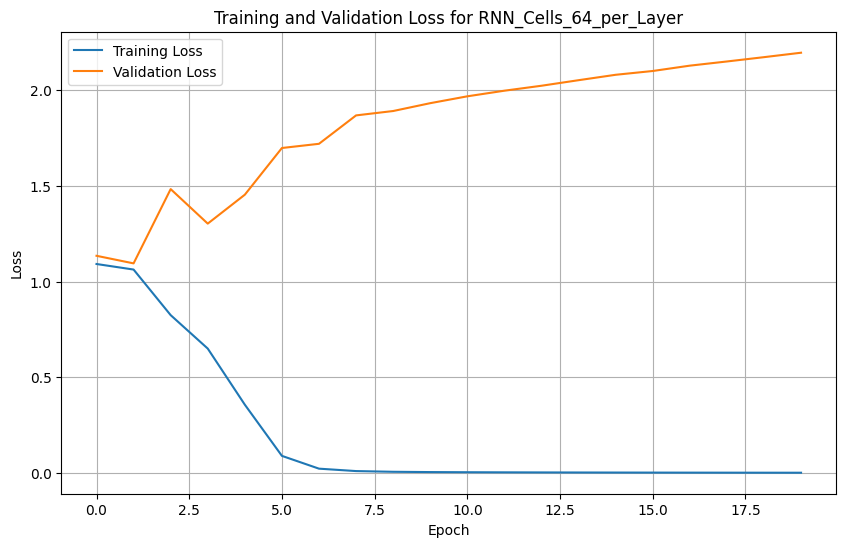


--- Melatih Model: RNN_Cells_128_per_Layer ---
Hasil Prediksi Akhir (RNN_Cells_128_per_Layer) pada Test Set: ACCURACY = 0.5225


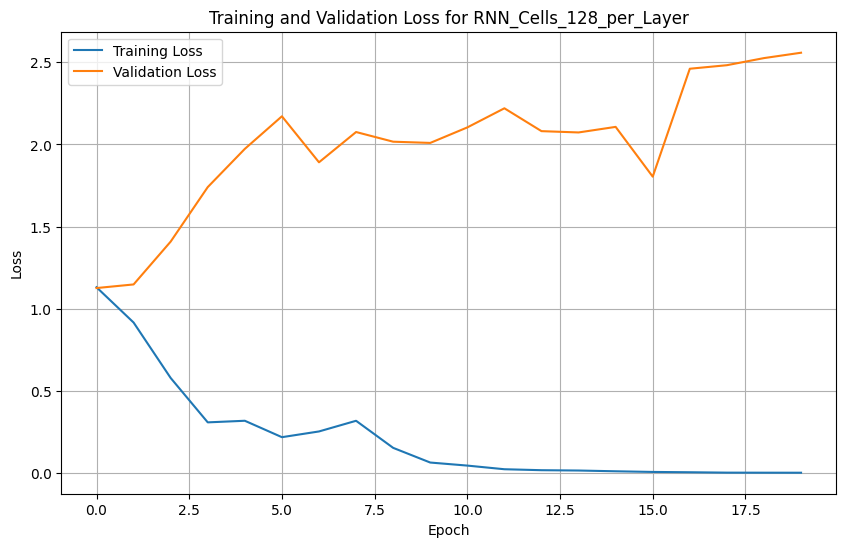


--- Perbandingan Hasil Akhir Prediksi (Banyak Cell per Layer) ---
RNN_Cells_32_per_Layer: ACCURACY = 0.4025
RNN_Cells_64_per_Layer: ACCURACY = 0.4000
RNN_Cells_128_per_Layer: ACCURACY = 0.5225

--- Kesimpulan Pengaruh Banyak Cell RNN per Layer ---
Jumlah cell (unit) per layer menentukan kapasitas representasional dari layer tersebut.
Jumlah cell yang lebih banyak memungkinkan layer untuk mempelajari pola yang lebih kompleks.
Namun, terlalu banyak cell dapat menyebabkan overfitting, membutuhkan lebih banyak data pelatihan, dan meningkatkan waktu komputasi serta penggunaan memori.
Pilih jumlah cell yang optimal yang dapat menangkap kompleksitas data tanpa menyebabkan overfitting.
Perhatikan juga trade-off antara kinerja dan sumber daya komputasi.


In [23]:
### Pengaruh Banyak Cell RNN per Layer
print("\n===== Eksperimen: Pengaruh Banyak Cell RNN per Layer =====")
cells_per_layer_variations = [32, 64, 128]
num_layers_for_cell_exp = DEFAULT_NUM_LAYERS

results_cells_per_layer = {}

for n_cells in cells_per_layer_variations:
    cells_config = [n_cells] * num_layers_for_cell_exp
    model_name = f'RNN_Cells_{n_cells}_per_Layer'
    model = build_rnn_model(input_shape, output_units, vocab_size, embedding_dim,
                            num_layers=num_layers_for_cell_exp,
                            cells_per_layer=cells_config,
                            rnn_layer_type=DEFAULT_RNN_TYPE,
                            bidirectional=False)
    _, final_metric = train_and_plot(model, X_train, y_train, X_val, y_val,
                                     model_name, epochs=DEFAULT_EPOCHS, batch_size=DEFAULT_BATCH_SIZE)
    results_cells_per_layer[model_name] = final_metric

print("\n--- Perbandingan Hasil Akhir Prediksi (Banyak Cell per Layer) ---")
for name, metric in results_cells_per_layer.items():
    print(f"{name}: {metrics_list[0].upper()} = {metric:.4f}")

print("\n--- Kesimpulan Pengaruh Banyak Cell RNN per Layer ---")
print("Jumlah cell (unit) per layer menentukan kapasitas representasional dari layer tersebut.")
print("Jumlah cell yang lebih banyak memungkinkan layer untuk mempelajari pola yang lebih kompleks.")
print("Namun, terlalu banyak cell dapat menyebabkan overfitting, membutuhkan lebih banyak data pelatihan, dan meningkatkan waktu komputasi serta penggunaan memori.")
print("Pilih jumlah cell yang optimal yang dapat menangkap kompleksitas data tanpa menyebabkan overfitting.")
print("Perhatikan juga trade-off antara kinerja dan sumber daya komputasi.")


===== Eksperimen: Pengaruh Jenis Layer RNN Berdasarkan Arah =====

--- Melatih Model: RNN_Direction_Unidirectional ---
Hasil Prediksi Akhir (RNN_Direction_Unidirectional) pada Test Set: ACCURACY = 0.4225


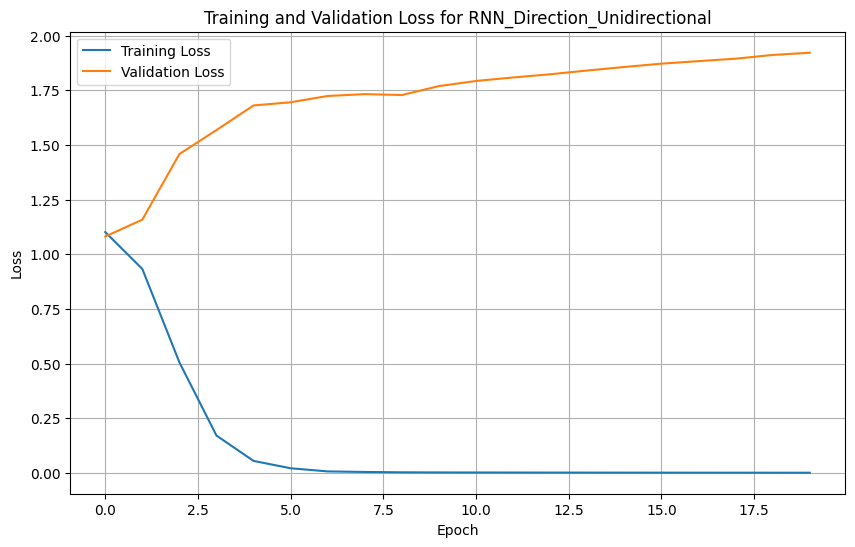


--- Melatih Model: RNN_Direction_Bidirectional ---
Hasil Prediksi Akhir (RNN_Direction_Bidirectional) pada Test Set: ACCURACY = 0.4775


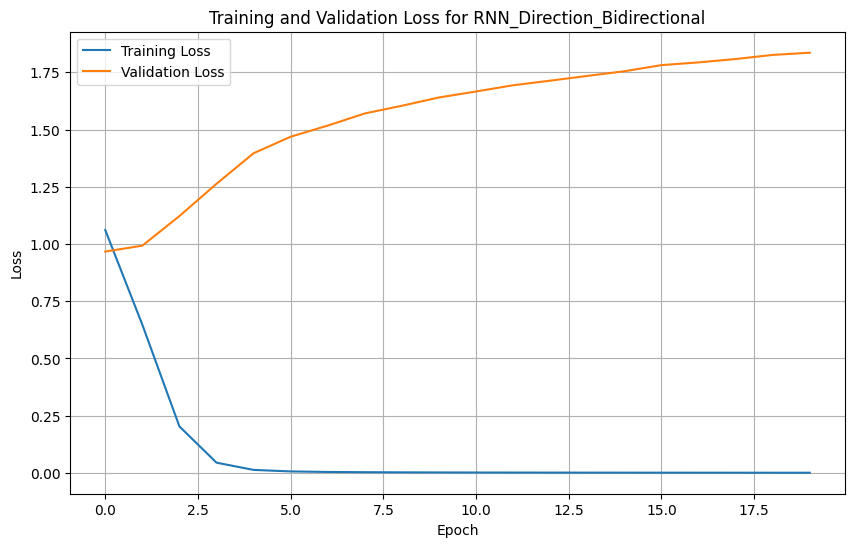


--- Perbandingan Hasil Akhir Prediksi (Jenis Arah Layer) ---
RNN_Direction_Unidirectional: ACCURACY = 0.4225
RNN_Direction_Bidirectional: ACCURACY = 0.4775

--- Kesimpulan Pengaruh Jenis Layer RNN Berdasarkan Arah ---
Unidirectional RNN (misalnya LSTM biasa) memproses sekuens dari awal hingga akhir (masa lalu ke masa depan).
Bidirectional RNN memproses sekuens dari dua arah: dari awal ke akhir dan dari akhir ke awal. Ini memungkinkan model untuk menangkap konteks dari masa lalu dan masa depan pada setiap titik waktu.
Bidirectional RNN seringkali lebih baik untuk tugas-tugas di mana konteks dari kedua arah penting (misalnya, pemrosesan bahasa alami).
Namun, Bidirectional RNN memiliki kompleksitas komputasi yang lebih tinggi dan membutuhkan lebih banyak memori karena melatih dua RNN secara paralel.
Pilih bidirectional jika konteks 'masa depan' dari sekuens penting untuk prediksi saat ini; jika tidak, unidirectional mungkin cukup dan lebih efisien.


In [24]:
### Pengaruh Jenis Layer RNN Berdasarkan Arah (Bidirectional vs Unidirectional)
print("\n===== Eksperimen: Pengaruh Jenis Layer RNN Berdasarkan Arah =====")
bidirectional_variations = [False, True]
num_layers_for_direction_exp = DEFAULT_NUM_LAYERS
cells_per_layer_for_direction_exp = DEFAULT_CELLS_PER_LAYER

results_direction = {}

for is_bidirectional in bidirectional_variations:
    direction_type = "Bidirectional" if is_bidirectional else "Unidirectional"
    model_name = f'RNN_Direction_{direction_type}'
    model = build_rnn_model(input_shape, output_units, vocab_size, embedding_dim,
                            num_layers=num_layers_for_direction_exp,
                            cells_per_layer=cells_per_layer_for_direction_exp,
                            rnn_layer_type=DEFAULT_RNN_TYPE,
                            bidirectional=is_bidirectional)
    _, final_metric = train_and_plot(model, X_train, y_train, X_val, y_val,
                                     model_name, epochs=DEFAULT_EPOCHS, batch_size=DEFAULT_BATCH_SIZE)
    results_direction[model_name] = final_metric

print("\n--- Perbandingan Hasil Akhir Prediksi (Jenis Arah Layer) ---")
for name, metric in results_direction.items():
    print(f"{name}: {metrics_list[0].upper()} = {metric:.4f}")

print("\n--- Kesimpulan Pengaruh Jenis Layer RNN Berdasarkan Arah ---")
print("Unidirectional RNN (misalnya LSTM biasa) memproses sekuens dari awal hingga akhir (masa lalu ke masa depan).")
print("Bidirectional RNN memproses sekuens dari dua arah: dari awal ke akhir dan dari akhir ke awal. Ini memungkinkan model untuk menangkap konteks dari masa lalu dan masa depan pada setiap titik waktu.")
print("Bidirectional RNN seringkali lebih baik untuk tugas-tugas di mana konteks dari kedua arah penting (misalnya, pemrosesan bahasa alami).")
print("Namun, Bidirectional RNN memiliki kompleksitas komputasi yang lebih tinggi dan membutuhkan lebih banyak memori karena melatih dua RNN secara paralel.")
print("Pilih bidirectional jika konteks 'masa depan' dari sekuens penting untuk prediksi saat ini; jika tidak, unidirectional mungkin cukup dan lebih efisien.")

# Welcome to Colab!

## Explore the Gemini API
The Gemini API gives you access to Gemini models created by Google DeepMind. Gemini models are built from the ground up to be multimodal, so you can reason seamlessly across text, images, code, and audio.

**How to get started?**
*  Go to [Google AI Studio](https://aistudio.google.com/) and log in with your Google account.
*  [Create an API key](https://aistudio.google.com/app/apikey).
* Use a quickstart for [Python](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started.ipynb), or call the REST API using [curl](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/rest/Prompting_REST.ipynb).

**Discover Gemini's advanced capabilities**
*  Play with Gemini [multimodal outputs](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Image-out.ipynb), mixing text and images in an iterative way.
*  Discover the [multimodal Live API](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_LiveAPI.ipynb ) (demo [here](https://aistudio.google.com/live)).
*  Learn how to [analyze images and detect items in your pictures](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Spatial_understanding.ipynb") using Gemini (bonus, there's a [3D version](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Spatial_understanding_3d.ipynb) as well!).
*  Unlock the power of [Gemini thinking model](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Get_started_thinking.ipynb), capable of solving complex task with its inner thoughts.
      
**Explore complex use cases**
*  Use [Gemini grounding capabilities](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Search_grounding_for_research_report.ipynb) to create a report on a company based on what the model can find on internet.
*  Extract [invoices and form data from PDF](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Pdf_structured_outputs_on_invoices_and_forms.ipynb) in a structured way.
*  Create [illustrations based on a whole book](https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Book_illustration.ipynb) using Gemini large context window and Imagen.

To learn more, check out the [Gemini cookbook](https://github.com/google-gemini/cookbook) or visit the [Gemini API documentation](https://ai.google.dev/docs/).


Colab now has AI features powered by [Gemini](https://gemini.google.com). The video below provides information on how to use these features, whether you're new to Python, or a seasoned veteran.

<center>
  <a href="https://www.youtube.com/watch?v=V7RXyqFUR98" target="_blank">
  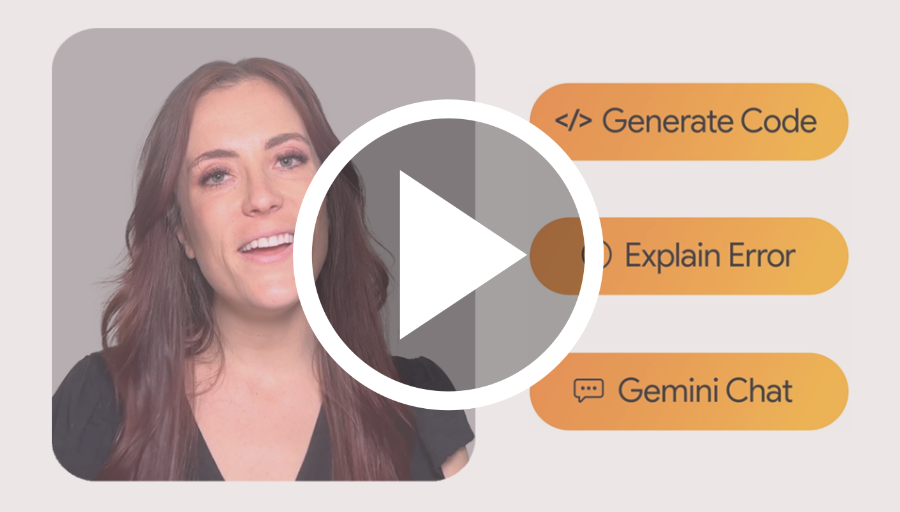
  </a>
</center>

<div class="markdown-google-sans">
  <h2>What is Colab?</h2>
</div>

Colab, or "Colaboratory", allows you to write and execute Python in your browser, with
- Zero configuration required
- Access to GPUs free of charge
- Easy sharing

Whether you're a **student**, a **data scientist** or an **AI researcher**, Colab can make your work easier. Watch [Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) or [Colab Features You May Have Missed](https://www.youtube.com/watch?v=rNgswRZ2C1Y) to learn more, or just get started below!

<div class="markdown-google-sans">

## **Getting started**
</div>

The document you are reading is not a static web page, but an interactive environment called a **Colab notebook** that lets you write and execute code.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [ ]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter". To edit the code, just click the cell and start editing.

Variables that you define in one cell can later be used in other cells:

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

Colab notebooks allow you to combine **executable code** and **rich text** in a single document, along with **images**, **HTML**, **LaTeX** and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To learn more, see [Overview of Colab](/notebooks/basic_features_overview.ipynb). To create a new Colab notebook you can use the File menu above, or use the following link: [create a new Colab notebook](http://colab.research.google.com#create=true).

Colab notebooks are Jupyter notebooks that are hosted by Colab. To learn more about the Jupyter project, see [jupyter.org](https://www.jupyter.org).

<div class="markdown-google-sans">

## Data science
</div>

With Colab you can harness the full power of popular Python libraries to analyze and visualize data. The code cell below uses **numpy** to generate some random data, and uses **matplotlib** to visualize it. To edit the code, just click the cell and start editing.

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from Github and many other sources. To learn more about importing data, and how Colab can be used for data science, see the links below under [Working with Data](#working-with-data).

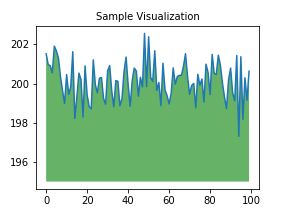

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including [GPUs and TPUs](#using-accelerated-hardware), regardless of the power of your machine. All you need is a browser.

For example, if you find yourself waiting for **pandas** code to finish running and want to go faster, you can switch to a GPU Runtime and use libraries like [RAPIDS cuDF](https://rapids.ai/cudf-pandas) that provide zero-code-change acceleration.

To learn more about accelerating pandas on Colab, see the [10 minute guide](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_colab_demo.ipynb) or
 [US stock market data analysis demo](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_stocks_demo.ipynb).

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb).

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the [machine learning examples](#machine-learning-examples) below.

<div class="markdown-google-sans">

## More Resources

### Working with Notebooks in Colab

</div>

- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with Data
</div>

- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning

<div>

These are a few of the notebooks related to Machine Learning, including Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Intro to RAPIDS cuDF to accelerate pandas](https://nvda.ws/rapids-cudf)
- [Getting Started with cuML's accelerator mode](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cuml_sklearn_colab_demo.ipynb)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
</div>

- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TPUs in Colab](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.
